<a href="https://colab.research.google.com/github/ignacioPadilla/inteligenciaProyecto/blob/main/COPIA_de_Proyecto_Inteligencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pathlib
import time

import torch
from torch import nn
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Datasets a utilizar**

In [38]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Localización de husos sigma en el EEG del sueño'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
#TRAIN
#signals son las señales completas, cada señal se compone de 800 puntos(4463 señales).
dir_train_signals = path + "/train_signals.npy"
train_signals = torch.from_numpy(np.load(pathlib.Path(dir_train_signals))) #Tiene una señal muestreada con valores reales como Tensor



#marks son las respuestas, en cual punto comienza y termina el huso sigma.
dir_train_marks = path + "/train_marks.npy"
train_marks = np.load(pathlib.Path(dir_train_marks))  

#TEST
dir_test_signals = path + "/test_signals.npy"
test_signals = torch.from_numpy(np.load(pathlib.Path(dir_test_signals))) #Tiene una señal muestreada con valores reales como Tensor 

dir_test_marks = path + "/test_marks.npy"
test_marks = np.load(pathlib.Path(dir_test_marks))

#VALIDATION
dir_val_signals = path + "/val_signals.npy"
val_signals = torch.from_numpy(np.load(pathlib.Path(dir_val_signals))) #Tiene una señal muestreada con valores reales como Tensor

dir_val_marks = path + "/val_marks.npy"
val_marks = np.load(pathlib.Path(dir_val_marks))


## ***Exploración de datos***

## Datos tipo "signals"

In [ ]:
print("Las dimensiones de train signal son:")
print(train_signals.shape)
print("Lo que quiere decir que tenemos 4463 señales con 800 muestras")
print()
print("Las dimensiones de test signal son: ")
print(test_signals.shape)
print("Lo que quiere decir que tenemos 2256 señales con 800 muestras")
print()
print("Las dimensiones de val signal son:")
print(val_signals.shape)
print("Lo que quiere decir que tenemos 1808 señales con 800 muestras")

Las dimensiones de train signal son:
torch.Size([4463, 800])
Lo que quiere decir que tenemos 4463 señales con 800 muestras

Las dimensiones de test signal son: 
torch.Size([2256, 800])
Lo que quiere decir que tenemos 2256 señales con 800 muestras

Las dimensiones de val signal son:
torch.Size([1808, 800])
Lo que quiere decir que tenemos 1808 señales con 800 muestras


## Gráfico de una señal tipo signal

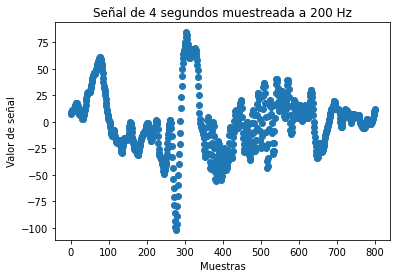

In [ ]:
muestras=np.linspace(0, 800, num=800)
# Crear la figura y los ejes
fig, ax = plt.subplots()
plt.xlabel('Muestras')
plt.ylabel('Valor de señal')
plt.title('Señal de 4 segundos muestreada a 200 Hz')
# Dibujar puntos
ax.scatter(muestras, train_signals[40])
# Mostrar el gráfico
plt.show()

El segmento anterior tiene una duración de 4 segundos y fue muestreado a una frecuencia de 200Hz, es por ello que se tienen 800 muestras

## Datos tipo marks

In [ ]:
print("Las dimensiones de train marks son:")
print(train_marks.shape)
print("Lo que quiere decir que tenemos 4463 señales con su inicio y fin del huso del sueño")
print()
print("Las dimensiones de test marks son: ")
print(test_marks.shape)
print("Lo que quiere decir que tenemos 2256 señales con su inicio y fin del huso del sueño")
print()
print("Las dimensiones de val marks son:")
print(val_marks.shape)
print("Lo que quiere decir que tenemos 1808 señales con su inicio y fin del huso del sueño")

Las dimensiones de train marks son:
(4463, 2)
Lo que quiere decir que tenemos 4463 señales con su inicio y fin del huso del sueño

Las dimensiones de test marks son: 
(2256, 2)
Lo que quiere decir que tenemos 2256 señales con su inicio y fin del huso del sueño

Las dimensiones de val marks son:
(1808, 2)
Lo que quiere decir que tenemos 1808 señales con su inicio y fin del huso del sueño


A continuación con los datos de marks podemos obtener las CLASES para la señal tipo signal, ya que se sabe en que posicion empieza y termina el huso, es por ello que se define la función "crea_y" para poder obtener las clases

In [40]:
def crea_y(mark):
  muestras,dim = mark.shape
  salida=np.zeros(800)
  for i in range(muestras):
    vector = np.zeros(800)
    inicio = mark[i][0]
    final = mark[i][1]
    while inicio <= final:
      vector[inicio] = 1
      inicio = inicio+1
    salida = np.vstack([salida,vector])
  salida = np.delete(salida, 0, axis=0)
  return salida

In [41]:
y_train = crea_y(train_marks)
y_test = crea_y(test_marks)
y_val = crea_y(val_marks)

## Gráfico de husos del sueño para una señal


*   0=No hay huso de sueño
*   1=Hay huso de sueño







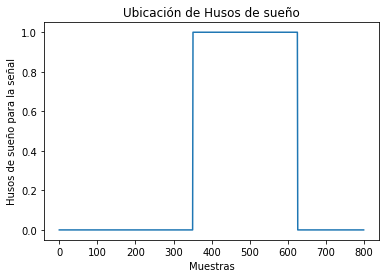

In [ ]:
### sanity check
plt.plot(y_train[40,:])
plt.xlabel('Muestras')
plt.ylabel('Husos de sueño para la señal')
plt.title('Ubicación de Husos de sueño')
plt.show()

# **Implementación de red neuronal**

In [42]:
#Clases para husos con 0 y 1
y_train = crea_y(train_marks) 
y_test = crea_y(test_marks)
y_val = crea_y(val_marks)

#De numpy a tensor
y_train = torch.tensor(y_train, dtype=torch.float64)
y_val = torch.tensor(y_val, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

#Redimensionar "y"

#y_train=torch.reshape(y_train,(len(y_train),1,1,800))
#y_val=torch.reshape(y_val,(len(y_val),1,1,800))
#y_test=torch.reshape(y_test,(len(y_test),1,1,800))

#Se cambian dimensiones a las señales tipo signals para que tengan un canal y poder ocupar red convolucional
X_train = torch.reshape(train_signals,(4463,1,800)) 
X_val = torch.reshape(val_signals,(len(val_signals),1,800))
X_test = torch.reshape(test_signals,(len(test_signals),1,800))

In [ ]:
print("Dimensiones de y_train:")
y_train.shape

Dimensiones de y_train:


torch.Size([4463, 800])

In [ ]:
print("Dimensiones de X_train:")
print(X_train.shape)
print("Tenemos 4463 datos de imagenes de 1x800 ")
print()
print("Dimensiones de X_val:")
print(X_val.shape)
print("Tenemos 1808 datos de imagenes de 1x800 ")
print()
print("Dimensiones de X_test:")
print(X_test.shape)
print("Tenemos 2256 datos de imagenes de 1x800 ")

Dimensiones de X_train:
torch.Size([4463, 1, 800])
Tenemos 4463 datos de imagenes de 1x800 

Dimensiones de X_val:
torch.Size([1808, 1, 800])
Tenemos 1808 datos de imagenes de 1x800 

Dimensiones de X_test:
torch.Size([2256, 1, 800])
Tenemos 2256 datos de imagenes de 1x800 


In [43]:
#DATASETS
train_dataset = torch.utils.data.TensorDataset(X_train, y_train) 
val_dataset = torch.utils.data.TensorDataset(X_val,y_val)
test_dataset =torch.utils.data.TensorDataset(X_test,y_test)

A continuación se prueba si los dataset cumplen la función de guardas las clases para las señales

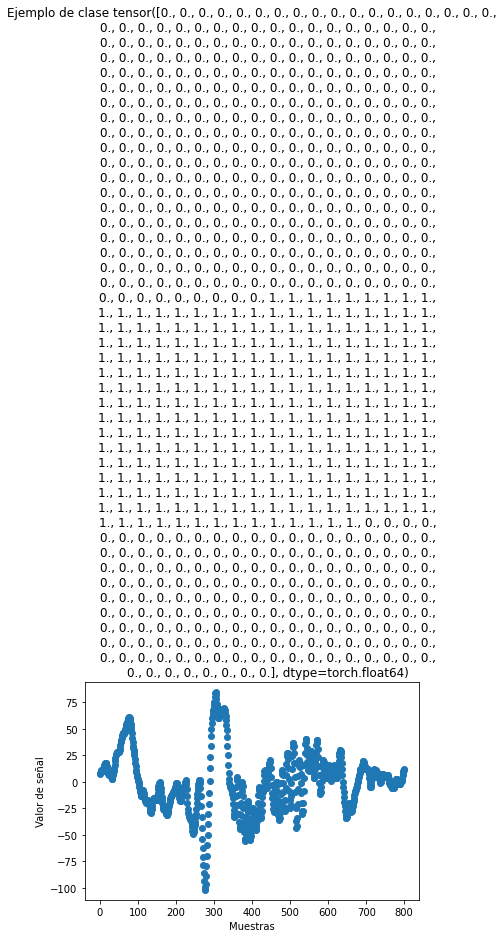

In [ ]:
example_image, example_class = train_dataset[40]
muestras=np.linspace(0, 800, num=800)
# Crear la figura y los ejes
fig, ax = plt.subplots()
plt.xlabel('Muestras')
plt.ylabel('Valor de señal')
plt.title(f"Ejemplo de clase {example_class}")
# Dibujar puntos
ax.scatter(muestras, example_image)
# Mostrar el gráfico
plt.show()

Cambio en las dimensiones al aplicar red convolucional a los datos

In [ ]:
example_image, example_class = train_dataset[40]
conv_layer = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=1)
output_image= conv_layer(example_image)
print(f"Input image shape: {example_image.shape}")
print(f"Output image shape: {output_image.shape}")

Input image shape: torch.Size([1, 800])
Output image shape: torch.Size([10, 800])


 ***RED NEURONAL ***

In [44]:
class CNNModel(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 16, kernel_size=1), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(16, 32, kernel_size=1),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(32, 1, kernel_size=1),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques
            nn.Linear(800, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
input=torch.from_numpy(np.array([70000,1,2,0.4,-1]))
m = nn.ReLU()
#input = torch.randn(2)
output = m(input)
print(output)
n=nn.Sigmoid()
output1=n(input)
print(output1)


tensor([7.0000e+04, 1.0000e+00, 2.0000e+00, 4.0000e-01, 0.0000e+00],
       dtype=torch.float64)
tensor([1.0000, 0.7311, 0.8808, 0.5987, 0.2689], dtype=torch.float64)


In [45]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [46]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    #Modelo entrenado con x_batch señales, el cual debería entregar una predicción de 800 números 
    #y a esa predicción hecha por el modela la llamamos "y_predicted"
    y_predicted = model(x_batch) #modelo entrega arreglo de 800 números con valores del 0 al 1

    #Loss es el criteio a utilizar para calcular la diferencia entre el "y_predicted"  y el "y_batch", para saber cuanto nos estamos equivocando
    loss = criterion(y_predicted, y_batch) 

    # Actualización de parámetros
    optimizer.zero_grad() 
    loss.backward() #el error debido a loss se propaga hacia atras
    optimizer.step()

    return y_predicted, loss #train_step entrena la red con señales de tamaño x_batch, luego calcula el loss para finalmente propagar el error hacia atras


###PARA VALIDACION####
def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0 #Los que iremos acumulando a medida que recorremos las señales y hacemos una predicción
    cumulative_predictions = 0
    data_count = 1808*800   #0
    data_count1=0
    for x_val, y_val in val_loader:  #toma una señal de x_val y su Clase de y_val y lo hace para todo el dataset val_loader
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val) #Hace una predicción para x_val con el modelo de redes neuronales. 
        
        loss = criterion(y_predicted, y_val) #Se calcula un loss para ver en cuanto difiere la predicción de la red con el valor real que deberia dar

        class_prediction = (y_predicted >= 0.5).long() #Esto trasnforma a 0 o 1 el arreglo de 800 elementos que tenemos
        
        cumulative_predictions += (y_val == class_prediction).sum().item() #SUMA CASOS CORRECTAMENTE PREDICHOS
        cumulative_loss += loss.item() #LOSS POR CADA SALIDA DE LA RED
        #data_count =1808*800   #CONTAMOS EL TOTAL DE CASOS#y_val.shape[1] #Cambiamos eso
        data_count1 +=1
        
    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count1 ################

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):


    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu) #batch size es de tamaño 1808

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader) #deberia ser 4463 

    for epoch in range(epochs): #si epochs es 4, entonces toma valores del 0 al 3 (creo)
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0
###########################
        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu) #Entrega el y predicted y el loss para una epoca

            cumulative_train_loss += loss.item() #Se acumula loss a medida que pasamos por los x_batch
            train_loss_count += 1   #800
            train_acc_count =4463*800   #Antes tenia y_batch.shape[0] #Puse eso pq es el total de casos de 0 y 1 de todo el dataset

            # Calculamos número de aciertos
            class_prediction = (y_predicted >= 0.5).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()



    return curves

Epoch 1/20
Iteration 11 - Batch 11/70 - Train loss: 20737.794677734375, Train acc: 0.11058900963477482
Iteration 22 - Batch 22/70 - Train loss: 16581.971509850544, Train acc: 0.23252688774367017
Iteration 33 - Batch 33/70 - Train loss: 14777.612735523897, Train acc: 0.3564261707371723
Iteration 44 - Batch 44/70 - Train loss: 13863.062131076389, Train acc: 0.48016020613936816
Iteration 55 - Batch 55/70 - Train loss: 13308.631574358258, Train acc: 0.6038827582343715
Iteration 66 - Batch 66/70 - Train loss: 12904.976679104477, Train acc: 0.7281990813354245
Val loss: 315688.71875, Val acc: 0.7817809734513275
Epoch 2/20
Iteration 81 - Batch 11/70 - Train loss: 11032.515950520834, Train acc: 0.13500588169392785
Iteration 92 - Batch 22/70 - Train loss: 10925.288765285326, Train acc: 0.25944207931884383
Iteration 103 - Batch 33/70 - Train loss: 10904.165383731617, Train acc: 0.3837275935469415
Iteration 114 - Batch 44/70 - Train loss: 10904.531293402777, Train acc: 0.5078674658301591
Iteration

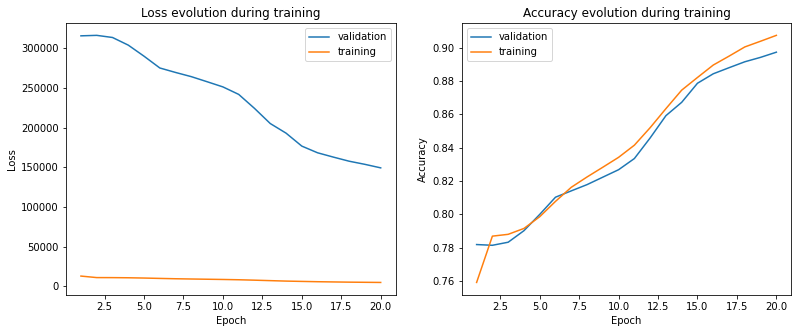

In [47]:
lr = 5e-4
dropout_p = 0.5
batch_size = 64
criterion = nn.L1Loss(reduction='sum')

epochs = 20
model = CNNModel(dropout_p=0.5)

curves = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False
)

show_curves(curves)